In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This notebook is dedicated for Data Cleaning, Text Preprocessing, some visualizations and model building.

# `Importing Libraries`

In [ ]:
# Install contractions library
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 10.3 MB/s eta 0:00:00


In [ ]:
!pip install pyspellchecker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 33.4 MB/s eta 0:00:00


In [ ]:
!pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 5.3 MB/s eta 0:00:00


In [ ]:
!pip install beautifulsoup4 lxml

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
import contractions
import random
from spellchecker import SpellChecker
from bs4 import BeautifulSoup
from unidecode import unidecode
import unicodedata
from collections import Counter
import itertools
import pickle

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer

import spacy

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, SpatialDropout1D, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import GRU

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## `Loading Data`

Here, the data loaded was from saved csv file from EDA file.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Fake_News_Classification/Data/titles_text_combined.csv')
df.head()

,Unnamed: 0,title,text,subject,date,label,title_length,text_length,full_text
0,2619,Ex-CIA head says Trump remarks on Russia inter...,Former CIA director John Brennan on Friday cri...,politicsNews,"July 22, 2017",1,67,2733,Ex-CIA head says Trump remarks on Russia inter...
1,16043,YOU WON’T BELIEVE HIS PUNISHMENT! HISPANIC STO...,How did this man come to OWN this store? There...,Government News,"Jun 19, 2017",0,121,2630,YOU WON’T BELIEVE HIS PUNISHMENT! HISPANIC STO...
2,876,Federal Reserve governor Powell's policy views...,President Donald Trump on Thursday tapped Fede...,politicsNews,"November 2, 2017",1,64,4052,Federal Reserve governor Powell's policy views...
3,19963,SCOUNDREL HILLARY SUPPORTER STARTS “TrumpLeaks...,Hillary Clinton ally David Brock is offering t...,left-news,"Sep 17, 2016",0,72,1131,SCOUNDREL HILLARY SUPPORTER STARTS “TrumpLeaks...
4,10783,NANCY PELOSI ARROGANTLY DISMISSES Questions on...,Pleading ignorance is a perfect ploy for Nancy...,politics,"May 26, 2017",0,104,1061,NANCY PELOSI ARROGANTLY DISMISSES Questions on...


In [ ]:
#Chechking Dimensions of data (no. of rows, no. of cols)
print(f"Dataset shape: {df.shape}")

Dataset shape: (27209, 9)


# `Text Cleaning`

### 1. **`StopWords Removal`**

What are StopWords ?

* Stop words, which are highly occurring words in the document such as ‘a’, ‘an’,’the’,’is’,’was’,’will’,’would’ etc.

* These words are highly occurring words in the document and to understand the document better we don’t need them because they don’t add any meaningful information.


In [ ]:
stopwordslist = stopwords.words('english')
print(stopwordslist)

print("\nTotal: ", len(stopwordslist))
print("\nPunctuation: ", string.punctuation)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

Some stopwords can be important in specific contexts, especially in NLP tasks like fake news detection, where certain stopwords may carry semantic or syntactic importance.

Words like **"not," "no," and "never"** are critical in understanding negation.

Prepositions like **"against"** or conjunctions like **"but"** may alter the sentiment in the text.

So we will customize our stopwords list and remove contextually important words from the list.


In [ ]:
#set of words to remove from stopwords as they can carry contextual importance
critical_words = {'not', 'no', 'but', 'against', 'because',
                  'who', 'why', 'until', 'nor',  'between'}

custom_stopwords = set(stopwordslist) - critical_words

print(f"\n{list(custom_stopwords)}")
print(f"\nLength: {len(custom_stopwords)}")


['theirs', 'whom', 're', 'couldn', 'won', 'yours', 'which', "won't", 'didn', 'did', 'i', 'wouldn', "you'll", 'mustn', "weren't", 'doing', 'each', 'their', 'her', 'yourselves', 'of', 'own', "she's", "you're", 'just', "wasn't", 'himself', 'she', 'd', 'his', 'it', 'they', 'to', 'these', 'as', 'how', 'its', 'shan', 'isn', 'herself', 'having', 'aren', "isn't", 'you', 'before', 'over', 'few', 'don', 'ma', 'o', 'and', 'there', 'should', 'hadn', "didn't", 'your', 'ain', 'down', "haven't", 'needn', 'both', 'here', "shan't", 'our', 'once', 'off', 'have', 'does', 'about', "don't", 'y', "mightn't", 'if', 't', "needn't", "hadn't", 'any', 'other', 'itself', "you've", 'a', 'this', 'too', 've', 'into', 'been', 'again', 'by', 'more', "should've", 'doesn', 'hasn', 'for', 'while', 'll', "hasn't", 'when', 'from', "it's", 'them', 'are', 'yourself', 'then', "aren't", 'all', 'those', 'themselves', 'most', 'now', 'above', 'haven', "wouldn't", 'below', 'an', 'he', 'up', 'some', 'same', 'what', 'be', 'on', 'm'

### 2. **`Dealing with Contractions`**

Contractions are shortened forms of words or phrases (e.g., "can't" → "cannot"), and expanding them ensures consistency and improves model performance.

Why Expand Contractions?
1. Improved Context Understanding
2. Consistency: Avoids treating "don't" and "do not" as separate entities during tokenization.

*  Some NLP libraries have built-in methods for expanding contractions. Here I will use the contractions library.

In [ ]:
#Let's illustrate it with a simple example how it works
text = "I can't believe it's happening. They're serious!"
expanded_text = contractions.fix(text)
print(expanded_text)

I cannot believe it is happening. They are serious!


The above text was expanded after using the contractions library. So we need to incorporate this step in our text cleaning method.

## 3. **`Standardizing and Spell Check`**

Why Check Spelling?
1. Fake news often has a higher density of spelling errors due to lower quality control.
2. Real news undergoes editorial processes, ensuring spelling accuracy.

In [ ]:
fake_news = random.sample(df[df['label'] == 0]['full_text'].tolist(), k=1)
fake_news

['TERROR EXPERT WARNS: If ISIS Isn’t Stopped, Europe Will Become Urban War Zone We need to have an honest conversation.  Well, that certainly would be refreshing Western powers must ramp up air strikes by 10 to 20 times to have any hope of disrupting the Islamic State group, which risks turning Europe into an urban guerrilla warzone, warned one of the world s leading counter-terrorism experts.David Kilcullen, an Australian army veteran, became the senior counter-insurgency advisor to US General David Petraeus during the Iraq War and is considered a key architect of the  Awakening  strategy that helped turn the conflict around.In an exclusive interview, he told AFP the Paris attacks showed the Islamic State group (IS) was morphing from a terrorist threat into a  structured organisation  like the IRA in Ireland or ETA in Spain during the 20th century. It s early days but I think we are starting to see the emergence of a fairly widespread paramilitary underground movement in Western Europ

In [ ]:
# Initialize spell checker
spell = SpellChecker()

def count_spelling_errors(text):
  words = text.split()
  words_count = len(words)
  misspelled = spell.unknown(words)
  error_count = len(misspelled)
  error_density = round(error_count / len(words), 3) if len(words) > 0 else 0

  for i, word in enumerate(misspelled):
    if(i == 6):
      break
    print(word)

  return error_count, error_density, words_count

In [ ]:
#passing the above random fake news to the function
errors, density, total_words = count_spelling_errors(str(fake_news))
print(f"Spelling Errors: {errors}, Error Density: {density}, Total Words: {total_words}")

frankly,
['terror
washington,
isn’t
troops.
combat,
Spelling Errors: 55, Error Density: 0.135, Total Words: 406


In [ ]:
real_news = random.sample(df[df['label'] == 1]['full_text'].tolist(), k=1)
real_news

['Merkel: I will announce decision on fourth term at right time German Chancellor Angela Merkel said on Thursday she would announce at the appropriate moment whether she will run for a fourth term next year, adding “that is not today.”  She was speaking during a news conference in Berlin with U.S. President Barack Obama who said he might vote for Merkel if he was German. “Merkel has been an outstanding partner,” Obama said. Many in Germany expect Merkel to run in a general election next year in which her conservatives are expected to remain the largest bloc in parliament.']

In [ ]:
#passing the above random real news to the function
errors, density, total_words = count_spelling_errors(str(real_news))
print(f"Spelling Errors: {errors}, Error Density: {density}, Total Words: {total_words}")

['merkel:
“merkel
today.”
year,
“that
german.
Spelling Errors: 11, Error Density: 0.111, Total Words: 99


The spelling errors reported in our news articles  seem to include words that are correctly spelled but flagged as errors.

This often happens because the **spellchecker library uses a basic dictionary** and might not recognize: Proper Nouns ,Domain-Specific Terms, Contractions, Words with Mixed Case or Hyphens(e.g., "cnn:after").

**So it is not logical to include this as one of the step in cleaning process.**

In [ ]:
# Function to check for Accented Characters like é, ó, or â

def contains_accented_characters(text):
  # Regex pattern to detect accented characters
  accented_char_pattern = re.compile(r'[^\x00-\x7F]')
  return bool(accented_char_pattern.search(text))

In [ ]:
accented_chars_rows = df[df['full_text'].apply(contains_accented_characters)]

#Get the count of rows with accented characters
count_accented = len(accented_chars_rows)
print(f"Count of rows with accented characters: {count_accented}")

Count of rows with accented characters: 15096


unidecode library can be used to normalize text by converting accented characters to their closest ASCII equivalents.

This ensures better compatibility with downstream processing and models.

In [ ]:
# Run this to Install the medium(md) Model
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 17.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## `clean_text function`:
Now, I will create a function that combines the text cleaning methods and cleans the 'full_text' column.

In [ ]:
#Loading spacy english model and stopwords outside the function
nlp = spacy.load('en_core_web_md')

from spacy.lang.en.stop_words import STOP_WORDS

critical_words = {'not', 'no', 'but', 'against',
                  'because', 'who', 'why', 'until', 'nor',  'between'}
custom_stopwords = set(spacy.lang.en.stop_words.STOP_WORDS) - critical_words

In [ ]:
# Combining regex patterns for efficiency

def clean_text(article):
  '''
    Cleans the input text by removing noise, normalizing text, and lemmatizing.

    Parameters:
        article (str): The input text to clean.

    Returns:
        str: Cleaned and lemmatized text.
  '''
  # 1. Patterns to search for...
  combined_pattern = (
      r'[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)|https?:\S+\s*|'
      r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b|'
      r'[@#]+(\w+)'
  )
  dates_pattern = r'\b\w+\s(?:\d{1,2},\s)?\d{4}(?=\b|[^a-zA-Z0-9]|$)'
  monetary_pattern = r'[\$\€\£\₹]\s?\d+(?:,\d{3})*(?:\.\d+)?(?:\s?(million|billion|trillion|thousand|k|m))?'
  alphanumeric_pattern = r'\b\w*\d\w*\b'
  multiline_comments_pattern = r'/\*.*?\*/'  # Multiline comments
  misc_pattern = r'[“”"|()\[\]]|\bRT\b|[.,:!?]'  # Miscellaneous noise

  #2. Cleaning Text
  # Remove accents
  article = unicodedata.normalize('NFKD', article).encode('ascii', 'ignore').decode('utf-8', 'ignore')

  # Handle contractions
  article = contractions.fix(article)

  # Lowercase
  article = article.lower()

  # Remove HTML tags
  article = BeautifulSoup(article, 'lxml').get_text()

  #3. Apply regex substitutions
  article = re.sub(combined_pattern, ' ', article)    # Remove URLs, emails, mentions, hashtags
  article = re.sub(dates_pattern, 'DATE', article)  # Remove dates with DATE to carry contextual relevance
  article = re.sub(multiline_comments_pattern, '', article, flags=re.S)  # Remove multiline comments
  article = re.sub(monetary_pattern, 'MONEY_AMOUNT', article)   # Normalize monetary values
  article = re.sub(alphanumeric_pattern, '', article)   # Remove alphanumeric noise
  article = re.sub(misc_pattern, '', article)        # Remove miscellaneous noise
  article = re.sub(r'\s+', ' ', article).strip()  # Normalize spaces

  #4. Lemmatization and stopword removal
  doc = nlp(article)
  lemmatized_list = [
      token.text if token.text in { "MONEY_AMOUNT", "DATE" } else token.lemma_
      for token in doc
      if token.text not in custom_stopwords and not token.is_punct
    ]

  return " ".join(lemmatized_list)

Testing text cleaning on some sample articles

In [ ]:
sentence1 = '''If Jones wins on Tuesday, Republicans would control the Senate by a
slim 51-49 margin, giving Democrats much-needed momentum ahead of the November 12, 2018
congressional elections '''

clean_text(sentence1)

'jones win tuesday republicans control senate slim margin give democrat need momentum ahead DATE congressional election'

In [ ]:
#Testing on some sample article ...
sentence2 = df.iloc[695]['full_text']
sentence2

'Republican Moore embraces Trump message on eve of Alabama election Dogged by accusations of sexual misconduct toward teenagers, Republican U.S. Senate candidate Roy Moore cast himself as a staunch ally of President Donald Trump at a rally on the eve of Tuesday’s election in Alabama. Despite Trump’s endorsement for Moore, some polls suggest Democrat Doug Jones, 63, a former U.S. attorney, could pull off an upset victory by becoming the first non-Republican to be sent to the Senate by deeply conservative Alabama in two decades. Steve Bannon, Trump’s former chief strategist and executive at the right-wing Breitbart News site, joined Moore in Midland City for the Monday night rally, labeled a “Drain the Swamp” event, in an echo of Trump’s 2016 campaign pledge to get rid of Washington insiders. “I want to make America great again with President Trump,” Moore said. “I want America great, but I want America good, and she can’t be good until we go back to God.” Moore, a 70-year-old conservati

In [ ]:
clean_text(sentence2)

'republican moore embrace trump message eve alabama election dog accusation sexual misconduct teenager republican yous senate candidate roy moore cast staunch ally president donald trump rally eve tuesday election alabama despite trumps endorsement moore poll suggest democrat doug jones yous attorney pull upset victory non republican send senate deeply conservative alabama decade steve bannon trump chief strategist executive right wing breitbart news site join moore midland city monday night rally label drain swamp event echo DATE campaign pledge rid washington insider want america great president trump moore say want america great but want america good not good until god moore -year old conservative christian alabama supreme court chief justice accuse woman pursue teenager include woman who say try initiate sexual contact moore deny misconduct reuter not independently verify accusation alabama race divide trump republican party sexual misconduct accusation prompt senior republican inc

In [ ]:
sentence3 = df.iloc[2495]['full_text']
sentence3

'Tea Party Superstar Gets WRECKED After Obama ‘N****r’ Tweet Tea Party darling and deadbeat dad extraordinaire Joe Walsh managed to be douchier than is typical on Sunday when he attacked Michael Che for saying something mean about Donald Trump.It may seem nonsensical that the  fuck your feelings  crowd gets sad every time someone says something to  trigger  them, but Walsh apparently needs a safe space after SNL s Michael Che called Donald Trump a  cracker  (among other things).Like all conservatives at some point in their lives, Walsh became  economically disenfranchised  (the media s term for racism among Trump voters) enough upon hearing Trump described as a  cracker  (the name of an all-white minor league baseball team in Atlanta, Georgia in the early parts of last century) to bust out the  n*gger  word.Naturally, The People were not amused:You thinking there is any equivalence between those two words demonstrates how thoroughly out of touch you are.  bob clendenin (@bobclendenin) 

In [ ]:
clean_text(sentence3)

'tea party superstar get wreck obama n****r tweet tea party darling deadbeat dad extraordinaire joe walsh manage douchier typical sunday attack michael che say mean donald nonsensical fuck feeling crowd get sad time say trigger but walsh apparently need safe space snl s michael che call donald trump cracker thingslike conservative point life walsh economically disenfranchise medium s term racism trump voter hear trump describe cracker white minor league baseball team atlanta georgia early part century bust n*gger wordnaturally people not amusedyou think equivalence between word demonstrate thoroughly touch bob clendenin october white conservative want word bad weird kai october effort justify tweet word transparent vile john pavlovitz october fuck close joe way use n word no reason harribly bigly october pine day mediocre white man spout like adjective snarrky october white people call cracker people own oh right carling jaye october take severe beating joy reid who correctly point wal

In [ ]:
sentence4 = df.iloc[1855]['full_text']
sentence4

'Canadian Hilariously HUMILIATES Three Trump Supporters For Insulting His Country This is priceless.Donald Trump has not even taken office yet, but he and his supporters are already getting their asses handed to them by people from other countries and proving themselves to be complete embarrassments to our nation.When Trump attacked Union Steelworkers 1999 on Wednesday he did so using his favorite attack platform: Twitter.If United Steelworkers 1999 was any good, they would have kept those jobs in Indiana. Spend more time working-less time talking. Reduce dues  Donald J. Trump (@realDonaldTrump) December 8, 2016Of course, Trump took a lot of heat for attacking the labor union simply because they were telling the truth about his pathetic deal with Carrier. But something remarkable and hilarious occurred after a Canadian Twitter user responded to Trump.Matty Granger pointed out to Trump that Time Magazine gave him devil horns on the cover.. @realDonaldTrump The joke s on you, dude. @TIME

In [ ]:
clean_text(sentence4)

'canadian hilariously humiliate trump supporter insult country trump not take office but supporter get ass hand people country prove complete embarrassment trump attack union DATE wednesday favorite attack platform united DATE good keep job indiana spend time work time talk reduce due donald j trump december course trump take lot heat attack labor union simply because tell truth pathetic deal carrier but remarkable hilarious occur canadian twitter user respond granger point trump time magazine give devil horn cover joke s dude give devil horn matty granger december trump supporter respond write granger joke because live canada actually joke live canada deplorable december granger didn t let slide humiliate trump supporter point superiority canadian healthcare system fact canada enjoy period domestic tranquility tell free medical care lack civil unrest matty granger december trump supporter try jump but get smack lol free lol socialism retardedness fine studio DATE people income pay MON

The below news article was randomly taken from indian news website.

In [ ]:
sentence5 = '''
Five Indian fishermen were hurt after Sri Lankan Navy opened fire on them near Delft Island on Tuesday. India registered strong protest with Sri Lankan Acting High Commissioner in New Delhi who was called to the Ministry of External Affairs. “Our High Commission in Colombo has also raised the matter with the Ministry of Foreign Affairs of the Sri Lankan government,”
India’s Ministry of External Affairs said.Two of 13 fishermen, from Karaikal (Puducherry) and Tamil Nadu sustained serious injuries during the arrest, news agency PTI reported, citing a Puducherry government official. Both of them have been hospitalised at Jaffna Teaching Hospital and are under medical supervision. Three other fishermen sustained minor injuries and have been treated.
The remaining fishermen have been taken into custody, the official added.
Indian Consulate Officials in Jaffna have visited the fishermen at the hospital “to seek
their welfare and are extending all possible assistance to the fishermen and their families,” the press release said.
The arrests by the Sri Lankan navy took place after the group of fishermen allegedly crossed the International Maritime Boundary around Deft Island and were fishing in the territorial waters of the island nation. A mechanised vessel used by the fishermen has also been seized, PTI reported.
The Chief Minister of Puducherry N Rangasamy wrote to the External Affairs Minister S Jaishankar requesting him to take appropriate steps on priority with the Government of Sri Lanka for the release of all the arrested fishermen, a release from office of the Chief Minister said.
Rangasamy said in his letter that six fishermen from Karaikal (an enclave of Puducherry) and seven from Tamil Nadu had been taken into custody by the Sri Lankan navy.
The Government of India has always emphasised on the need to treat issues pertaining to fishermen in a humane and humanitarian manner, keeping in mind livelihood concerns. The use of force is not acceptable under any circumstances whatsoever. Existing understandings between the two Governments in this regard must be strictly observed,” the MEA release added.
'''

clean_text(sentence5)

'indian fisherman hurt sri lankan navy open fire near delft island tuesday india register strong protest sri lankan act high commissioner new delhi who call ministry external affair high commission colombo raise matter ministry foreign affair sri lankan government indias ministry external affair fisherman karaikal puducherry tamil nadu sustain injury arrest news agency pti report cite puducherry government official hospitalise jaffna teaching hospital medical supervision fisherman sustain minor injury treat remain fisherman take custody official add indian consulate official jaffna visit fisherman hospital seek welfare extend possible assistance fisherman family press release say arrest sri lankan navy take place group fisherman allegedly cross international maritime boundary deft island fish territorial water island nation mechanised vessel fisherman seize pti report chief minister puducherry n rangasamy write external affair minister s jaishankar request appropriate step priority gov

### Clean_Text Column :

Applying the text cleaning function to the 'full_text' column.

In [ ]:
df['cleaned_text'] = df['full_text'].apply(lambda x: clean_text(str(x)))

In [ ]:
df.head()

,Unnamed: 0,title,text,subject,date,label,title_length,text_length,full_text,cleaned_text
0,2619,Ex-CIA head says Trump remarks on Russia inter...,Former CIA director John Brennan on Friday cri...,politicsNews,"July 22, 2017",1,67,2733,Ex-CIA head says Trump remarks on Russia inter...,ex cia head say trump remark russia interferen...
1,16043,YOU WON’T BELIEVE HIS PUNISHMENT! HISPANIC STO...,How did this man come to OWN this store? There...,Government News,"Jun 19, 2017",0,121,2630,YOU WON’T BELIEVE HIS PUNISHMENT! HISPANIC STO...,not believe punishment hispanic store owner sw...
2,876,Federal Reserve governor Powell's policy views...,President Donald Trump on Thursday tapped Fede...,politicsNews,"November 2, 2017",1,64,4052,Federal Reserve governor Powell's policy views...,federal reserve governor powell policy view wo...
3,19963,SCOUNDREL HILLARY SUPPORTER STARTS “TrumpLeaks...,Hillary Clinton ally David Brock is offering t...,left-news,"Sep 17, 2016",0,72,1131,SCOUNDREL HILLARY SUPPORTER STARTS “TrumpLeaks...,scoundrel hillary supporter start trumpleaks c...
4,10783,NANCY PELOSI ARROGANTLY DISMISSES Questions on...,Pleading ignorance is a perfect ploy for Nancy...,politics,"May 26, 2017",0,104,1061,NANCY PELOSI ARROGANTLY DISMISSES Questions on...,nancy pelosi arrogantly dismiss question crook...


#### Save CSV File

In [ ]:
df.to_csv('/content/drive/MyDrive/Fake_News_Classification/Data/preprocessed_data.csv')

### Load Preprocessed CSV File

In [ ]:
clean_df = pd.read_csv('/content/drive/MyDrive/Fake_News_Classification/Data/preprocessed_data.csv', index_col=False)
clean_df.head()

,Unnamed: 0.1,Unnamed: 0,title,text,subject,date,label,title_length,text_length,full_text,cleaned_text
0,0,2619,Ex-CIA head says Trump remarks on Russia inter...,Former CIA director John Brennan on Friday cri...,politicsNews,"July 22, 2017",1,67,2733,Ex-CIA head says Trump remarks on Russia inter...,ex cia head say trump remark russia interferen...
1,1,16043,YOU WON’T BELIEVE HIS PUNISHMENT! HISPANIC STO...,How did this man come to OWN this store? There...,Government News,"Jun 19, 2017",0,121,2630,YOU WON’T BELIEVE HIS PUNISHMENT! HISPANIC STO...,not believe punishment hispanic store owner sw...
2,2,876,Federal Reserve governor Powell's policy views...,President Donald Trump on Thursday tapped Fede...,politicsNews,"November 2, 2017",1,64,4052,Federal Reserve governor Powell's policy views...,federal reserve governor powell policy view wo...
3,3,19963,SCOUNDREL HILLARY SUPPORTER STARTS “TrumpLeaks...,Hillary Clinton ally David Brock is offering t...,left-news,"Sep 17, 2016",0,72,1131,SCOUNDREL HILLARY SUPPORTER STARTS “TrumpLeaks...,scoundrel hillary supporter start trumpleaks c...
4,4,10783,NANCY PELOSI ARROGANTLY DISMISSES Questions on...,Pleading ignorance is a perfect ploy for Nancy...,politics,"May 26, 2017",0,104,1061,NANCY PELOSI ARROGANTLY DISMISSES Questions on...,nancy pelosi arrogantly dismiss question crook...


In [ ]:
clean_df.drop('Unnamed: 0.1', axis=1, inplace=True)

### Workflow:

    Data Preprocessing
        |
    Data Splitting
        |
    Tokenization and Padding
        |
    Embedding Layer
        |
    Model Building
        |
    Model Training

## `Data Splitting`

In [ ]:
clean_df['label'].value_counts()   # 0: Fake, 1: Real

,count
label,
1,14422
0,12787


In [ ]:
X = clean_df['cleaned_text']
y = clean_df['label']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
X[:5]

,cleaned_text
0,ex cia head say trump remark russia interferen...
1,not believe punishment hispanic store owner sw...
2,federal reserve governor powell policy view wo...
3,scoundrel hillary supporter start trumpleaks c...
4,nancy pelosi arrogantly dismiss question crook...


In [ ]:
print(f"Training Data Size: {X_train.shape}")
print(f"Testing Data Size: {X_test.shape}")
# Counting real and fake news
print(f"Real news articles in Training data: {(y_train == 1).sum()}")
print(f"Fake news articles in Training data: {(y_train == 0).sum()}")

Training Data Size: (21767,)
Testing Data Size: (5442,)
Real news articles in Training data: 11537
Fake news articles in Training data: 10230


## **`Tokenization and Padding`**

Here, I will use Keras Tokenizer for tokenizing and pad_sequences for equal-length sequences.

The Tokenizer from Keras is used to convert raw text into sequences of integers.

Let's first see how this Tokenizer works and what are its parameters.

#### Understanding NLP Keras Tokenizer

In [ ]:
# Sample data
#Sentence 1 has 4 words and Sentence 2 has 7 words.
sentences = ["I love deep learning", "do you like natural language processing ?"]

# Initialize Tokenizer
# Including oov_token to handle new words during testing/inference.
tokenizer = Tokenizer(num_words = 12, oov_token="<OOV>")
tokenizer.fit_on_texts(sentences)

# Word Index (word-to-integer mapping)
print(tokenizer.word_index)

# Convert texts to sequences
sequences = tokenizer.texts_to_sequences(sentences)
print(sequences)
print(f"Size of 1st Sentence: {len(sequences[0])}")
print(f"Size of 2nd Sentence: {len(sequences[1])}")

{'<OOV>': 1, 'i': 2, 'love': 3, 'deep': 4, 'learning': 5, 'do': 6, 'you': 7, 'like': 8, 'natural': 9, 'language': 10, 'processing': 11}
[[2, 3, 4, 5], [6, 7, 8, 9, 10, 11]]
Size of 1st Sentence: 4
Size of 2nd Sentence: 6


We can see that both the sentence dimension is different, to resolve this we will use padding to make all the sentences of same dimension. This can be either pre padding or post-padding.

In [ ]:
#Padding to ensure equal length
padded_sequences = pad_sequences(sequences, maxlen=7, padding='post') # 7 becoz of the longest sentence has 7 words.
print(padded_sequences)

[[ 2  3  4  5  0  0  0]
 [ 6  7  8  9 10 11  0]]


Now, we will use this to tokenize in our dataset.

**1. Choosing num_words (Vocabulary Size)**:
* The num_words parameter limits the tokenizer to the top N most frequent words in our dataset.


Small datasets (10K–50K samples): 10,000 to 20,000 words are often sufficient.

Balanced approach: Starting with num_words = 10,000 based on our dataset size.

Tuning: Later, we can experiment with 10,000 or 20,000 to see the impact.


**2. Choosing maxlen (Maximum Sequence Length)**:
* It determines how many tokens from each article we’ll keep after tokenization.
* Longer articles will be truncated, and shorter ones will be padded.

* We can Analyze Article Lengths: Will Check the distribution of article lengths to make an informed decision.
* 90–95% Coverage: Choose a length that covers 90–95% of articles without truncation.

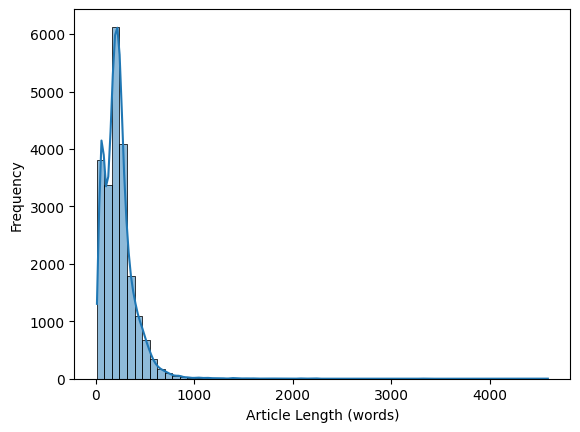

In [ ]:
article_lengths = [len(article.split()) for article in X_train]
sns.histplot(article_lengths, bins=60, kde=True)
plt.xlabel('Article Length (words)')
plt.ylabel('Frequency')
plt.show()

Based on the histogram:

Observations:
* The majority of articles are under 500 words, with a sharp decline after that.
* A small number of articles exceed 1000 words, but they're outliers.
* Most articles seem to peak between 200–300 words.

**Choosing maxlen:**
90–95% Coverage: Optimal Range: maxlen = 250 to 300 should cover over 90% of our articles.
This keeps important content while avoiding unnecessary padding.

Handling Outliers:
Articles >1000 words are rare, so truncating them won't significantly affect performance.

##### **Choosing num_words (Vocabulary Size) for Tokenizer**

In [ ]:
#Checking Unique Words in our Dataset
word_counts = Counter(itertools.chain(*[article.split() for article in clean_df['cleaned_text']]))
print(f"Total unique words: {len(word_counts)}")

Total unique words: 98548


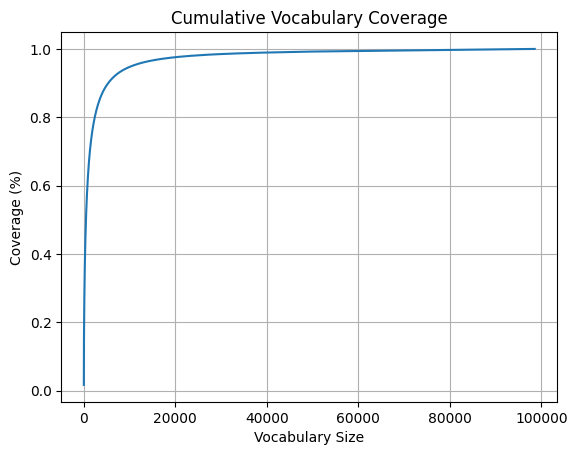

In [ ]:
#plotting a cumulative word frequency to find a good cutoff
sorted_counts = np.array(sorted(word_counts.values(), reverse=True))
cumulative_counts = np.cumsum(sorted_counts) / sum(sorted_counts)

plt.plot(cumulative_counts)
plt.xlabel("Vocabulary Size")
plt.ylabel("Coverage (%)")
plt.title("Cumulative Vocabulary Coverage")
plt.grid()
plt.show()

Observation:

* Our Cumulative Vocabularly Coverage plot shows that most of the coverage is achieved with a relatively small vocabulary size.

* The curve flattens out around 20,000 to 30,000 words, meaning adding more words beyond this point doesn't significantly increase coverage.

* Around 10,000 words, we likely cover 85-90% of the vocabulary used in our dataset.

For fast & efficient training → num_words = 10,000 (Covers ~85-90%)

In [ ]:
#Hyperparameters
num_words = 10000      # Vocabulary size
max_len = 300          # Max sequence length

# Tokenization
tokenizer = Tokenizer(num_words=num_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

In [ ]:
#Inspecting size after padding
X_train_pad[0].shape

(300,)

In [ ]:
#Save the Tokenizer
with open("/content/drive/MyDrive/Fake_News_Classification/Saved_Models/keras_tokenizer.pkl", 'wb') as f:
  pickle.dump(tokenizer, f)

# **`Embedding Layer`**

### Word Embeddings

Word embeddings are dense vector representations of words that capture their semantic meaning and relationships.

Static Vectors in Word Embeddings:
1. Word2Vec
2. GloVe
3. FastText

Contextual Word Embeddings:
1. BERT
2. RoBERTa
3. DistilBERT, etc..

Conclusion:
1.First, We will start with Glove for simplicity and efficiency.
2. Second, Contextual Embedding.


#### Download GloVe Pre-trained Embeddings

In [ ]:
#Set the Download Path
glove_dir = "/content/drive/MyDrive/Fake_News_Classification/Data"

In [ ]:
#Download GloVe and Move to Drive
!wget -P /content/drive/MyDrive/Fake_News_Classification/Data http://nlp.stanford.edu/data/glove.6B.zip


--2025-02-07 04:55:59--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-02-07 04:55:59--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-02-07 04:55:59--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘/content/drive/MyDr

In [ ]:
#Unzip the File
!unzip /content/drive/MyDrive/Fake_News_Classification/Data/glove.6B.zip -d /content/drive/MyDrive/Fake_News_Classification/Data

Archive:  /content/drive/MyDrive/Fake_News_Classification/Data/glove.6B.zip
  inflating: /content/drive/MyDrive/Fake_News_Classification/Data/glove.6B.50d.txt  
  inflating: /content/drive/MyDrive/Fake_News_Classification/Data/glove.6B.100d.txt  
  inflating: /content/drive/MyDrive/Fake_News_Classification/Data/glove.6B.200d.txt  
  inflating: /content/drive/MyDrive/Fake_News_Classification/Data/glove.6B.300d.txt  


This will give us multiple files:

glove.6B.50d.txt (50-dimensional embeddings)

glove.6B.100d.txt (100-dimensional embeddings)

glove.6B.200d.txt (200-dimensional embeddings)

glove.6B.300d.txt (300-dimensional embeddings)

* GloVe 100d is a good choice!

#### Load GloVe Embeddings

In [ ]:
# Path to the GloVe file
glove_file = "/content/drive/MyDrive/Fake_News_Classification/Data/glove.6B.100d.txt"
embedding_dim = 100

In [ ]:
#Loading Glove into dictionary
embedding_index = {}

with open(glove_file, encoding="utf-8") as f:
  for line in f:
    values = line.split()
    word = values[0]     # Length is 101. values[0] will be a word values[1:] will be vector form.
    vectors = np.asarray(values[1:], dtype='float32')
    embedding_index[word] = vectors

print(f"Loaded {len(embedding_index)} word vectors.")

Loaded 400000 word vectors.


#### Creating an Embedding Matrix

In [ ]:
#Vocab Size was 10,000
vocab_size = 10000      # Vocabulary size
embedding_dim = 100

embedding_matrix = np.zeros((vocab_size, embedding_dim))    # Zero Matrix with size (10000, 100)

for word, i in tokenizer.word_index.items():
  if i < vocab_size:
    embedding_vector = embedding_index.get(word)          # Get the vector form from the glove dict created above
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

print(f"Shape of embedding matrix: {embedding_matrix.shape}")

Shape of embedding matrix: (10000, 100)


## **BiLSTM**

Why use SpatialDropout1D?

* It works similarly to standard Dropout, but instead of dropping individual units randomly, it drops entire word vectors at once during training.

* When using embeddings (e.g., GloVe), some word representations might be too strongly correlated. SpatialDropout1D ensures that the model does not rely too much on certain word embeddings by randomly dropping them.
* Best for embedding layers in sequence models (LSTM, GRU, BiLSTM).

In [ ]:
vocab_size = 10000
max_len = 300

#Defining the model
bilstm_model = Sequential([
  Embedding(input_dim=vocab_size,
            output_dim=embedding_dim,
            weights=[embedding_matrix],
            input_length=max_len,
            trainable=False,
            name="Embedding_Layer",
             input_shape=(max_len,)),

  SpatialDropout1D(0.2, name="Dropout_Embedding"),

  Bidirectional(LSTM(units=128, return_sequences=True, recurrent_dropout=0.2, name="LSTM_1"),
                name="BiLSTM_1"),

  Bidirectional(LSTM(64, name="LSTM_2"), name="BiLSTM_2"),     # Reducing sequence to a fixed-size vector

  Dense(units=64, activation='relu', name="Dense_Hidden"),
  Dropout(0.3, name="Dropout_Hidden"),
  Dense(units=1, activation='sigmoid', name="Output_Layer")
])

#Compile the model
bilstm_model.compile(loss='binary_crossentropy',
                     optimizer=Adam(learning_rate=0.001),
                     metrics=['accuracy']
)

In [ ]:
# Model Summary
bilstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Embedding_Layer (Embedding)          │ (None, 300, 100)            │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_Embedding (SpatialDropout1D) │ (None, 300, 100)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BiLSTM_1 (Bidirectional)             │ (None, 300, 256)            │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BiLSTM_2 (Bidirectional)             │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_Hidden (Dense)                 │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_Hidden (Dropout)             │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Layer (Dense)                 │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,407,169 (5.37 MB)

 Trainable params: 407,169 (1.55 MB)

 Non-trainable params: 1,000,000 (3.81 MB)

In [ ]:
# Saving best model using ModelCheckpoint
checkpoint_path = "/content/drive/MyDrive/Fake_News_Classification/Saved_Models/bilstm_model.h5"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train the model
bilstm_history = bilstm_model.fit(
    X_train_pad, y_train,
    validation_split = 0.2,
    epochs=6,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/6
545/545 ━━━━━━━━━━━━━━━━━━━━ 1241s 2s/step - accuracy: 0.8613 - loss: 0.3192 - val_accuracy: 0.9479 - val_loss: 0.1390
Epoch 2/6
545/545 ━━━━━━━━━━━━━━━━━━━━ 1320s 2s/step - accuracy: 0.9495 - loss: 0.1380 - val_accuracy: 0.9704 - val_loss: 0.0859
Epoch 3/6
545/545 ━━━━━━━━━━━━━━━━━━━━ 1267s 2s/step - accuracy: 0.9698 - loss: 0.0828 - val_accuracy: 0.9763 - val_loss: 0.0625
Epoch 4/6
545/545 ━━━━━━━━━━━━━━━━━━━━ 1272s 2s/step - accuracy: 0.9780 - loss: 0.0615 - val_accuracy: 0.9793 - val_loss: 0.0575
Epoch 5/6
545/545 ━━━━━━━━━━━━━━━━━━━━ 1285s 2s/step - accuracy: 0.9848 - loss: 0.0451 - val_accuracy: 0.9800 - val_loss: 0.0625
Epoch 6/6
545/545 ━━━━━━━━━━━━━━━━━━━━ 1270s 2s/step - accuracy: 0.9879 - loss: 0.0375 - val_accuracy: 0.9858 - val_loss: 0.0561


### Observations:
1. High Accuracy
2. Decreasing Loss
3. No Overfitting Yet: The gap between training and validation accuracy is small.
Validation loss remains low, suggesting the model generalizes well.

In [ ]:
# Evaluating the Model
loss, accuracy = bilstm_model.evaluate(X_test_pad, y_test)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")

171/171 ━━━━━━━━━━━━━━━━━━━━ 77s 452ms/step - accuracy: 0.9843 - loss: 0.0514
Test Accuracy: 0.9846
Test Loss: 0.0550


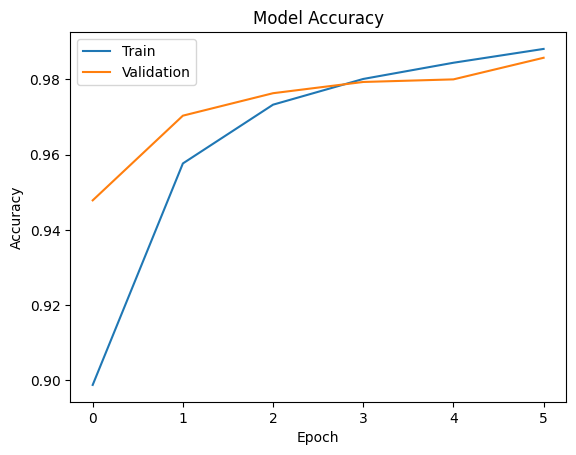

In [ ]:
# Plotting training & validation accuracy values
plt.plot(bilstm_history.history['accuracy'])
plt.plot(bilstm_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

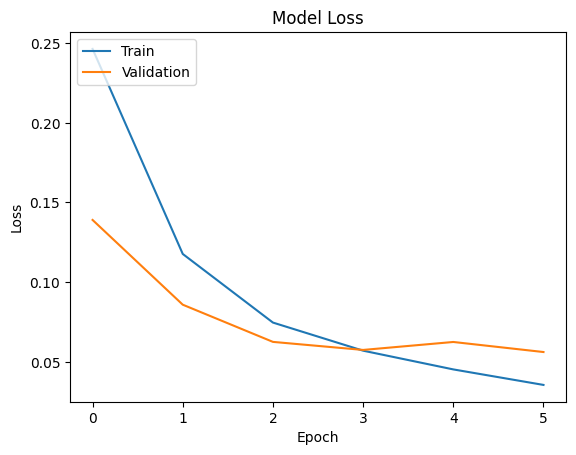

In [ ]:
# Plotting training & validation loss values
plt.plot(bilstm_history.history['loss'])
plt.plot(bilstm_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
y_pred_prob = bilstm_model.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype(int)

171/171 ━━━━━━━━━━━━━━━━━━━━ 98s 570ms/step


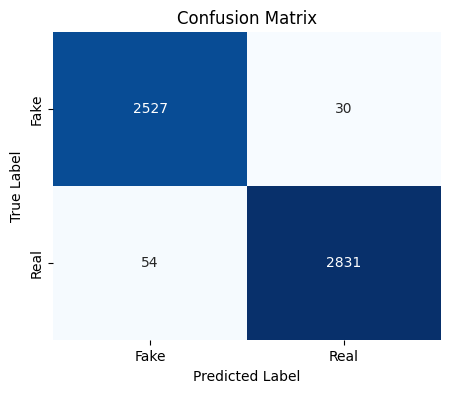

In [ ]:
# Generating confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])

# Labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(confusion_matrix(y_test, y_pred))

[[2527   30]
 [  54 2831]]


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2557
           1       0.99      0.98      0.99      2885

    accuracy                           0.98      5442
   macro avg       0.98      0.98      0.98      5442
weighted avg       0.98      0.98      0.98      5442



### Interpretation:
* High Precision (0.98 - 0.99) → The model rarely misclassifies fake/real news.
* High Recall (0.98 - 0.99) → The model detects almost all fake/real news correctly.
* Balanced F1-Scores (0.98 - 0.99) → The model maintains strong performance across both classes.

In [ ]:
bilstm_model.save("/content/drive/MyDrive/Fake_News_Classification/Saved_Models/bilstm_glove_model.h5")

In [ ]:
bilstm_model.save("/content/drive/MyDrive/Fake_News_Classification/Saved_Models/bilstm_glove_model.keras")

### Load the Saved BiLSTM Model

In [ ]:
# Load the model
bilstm_model = load_model("/content/drive/MyDrive/Fake_News_Classification/Saved_Models/bilstm_glove_model.keras")

### Load the Saved Keras Tokenizer

In [ ]:
# Load the saved keras tokenizer
with open("/content/drive/MyDrive/Fake_News_Classification/Saved_Models/keras_tokenizer.pkl", "rb") as handle:
    keras_tokenizer = pickle.load(handle)

In [ ]:
# Predict Using the Model
def predict_text(text):
  cleaned_text = clean_text(text)

  seq = keras_tokenizer.texts_to_sequences([cleaned_text])
  pad_seq = pad_sequences(seq, maxlen=300, padding='post')
  pred = bilstm_model.predict(pad_seq)[0][0]

  return "Real News" if pred >= 0.5 else "Fake News"

#### Random fake news example

In [ ]:
sample_text = '''NASA Confirms Earth Will Experience 15 Days of Total Darkness in March 2025
In a shocking revelation, NASA has confirmed that Earth will experience 15 consecutive days of total
darkness from March 10 to March 25, 2025 due to an astronomical event known as the “Blackout Alignment”.
According to NASA scientists, a rare planetary alignment between Jupiter and Venus will block out 90%
of sunlight reaching Earth, causing a global blackout.NASA Administrator Dr. Mark Reynolds stated
that this is a once-in-a-lifetime event, and people should prepare for extreme cold and power
failures during these two weeks. The government has urged citizens to stockpile food, water,
and emergency supplies. However, some experts warn that this could have serious effects on
human psychology and global economies. '''

predict_text(sample_text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


'Fake News'

#### Real news article based on recent global events:

In [ ]:
sample_news = ''''UN Calls for Immediate Ceasefire Amid Escalating Humanitarian Crisis in Gaza
The United Nations has issued an urgent call for an immediate ceasefire in Gaza, as the ongoing
conflict has led to a severe humanitarian crisis. UN Secretary-General António Guterres stated
that the situation has reached a catastrophic level, with thousands of civilians displaced and
essential infrastructure, including hospitals and schools, heavily damaged.International organizations,
including the Red Cross and Doctors Without Borders, have warned of critical shortages of food, water,
and medical supplies. Several world leaders, including US President Joe Biden and French President
Emmanuel Macron, have urged for diplomatic solutions to prevent further casualties.
Meanwhile, peace talks are set to continue under the mediation of Egypt and Qatar, aiming to
de-escalate tensions and bring both parties to a negotiation table.As tensions remain high,
world leaders are pushing for an end to hostilities and a long-term peace agreement in the region.
'''

predict_text(sample_news)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


'Real News'

### Observation:
* **Our BiLSTM model is accurately classifying real-world articles as fake or real**.

### **GRU(Gated Recurrent Model)**

Trying GRU (Gated Recurrent Unit) can give me insights into how different architectures perform on our fake news classification task.

Why Try GRU?
* Faster Training – GRU has fewer parameters than LSTMs/BiLSTMs, so it trains faster.
* Similar Performance – Often performs comparably to LSTMs, especially when the dataset isn't too large.
* Less Prone to Overfitting – Since it has fewer gates than LSTM, it might generalize better in some cases.

#### Workflow of GRU:

```
Loading Tokenizer & Data
        |
Build & Train GRU Model
        |
Comparing Performance
```

In [ ]:
#model hyperparameters
vocab_size = 10000   # Vocabulary size
max_len = 300        # Maximum sequence length
embedding_dim = 100  # Dimension of word embeddings

#Defining the gru model
gru_model = Sequential([
  Embedding(input_dim=vocab_size,
            output_dim=embedding_dim,
            weights=[embedding_matrix],
            input_length=max_len,
            trainable=False,       # Freeze embeddings to prevent modification
            name="Embedding_Layer",
            input_shape=(max_len,)),

  # Spatial Dropout: Randomly drops entire word embeddings to improve generalization
  #Increased Dropout from 0.2 -> 0.3
  SpatialDropout1D(0.3, name="Dropout_Embedding"),

  # First Bidirectional GRU: Processes text in both forward and backward directions
  Bidirectional(GRU(units=128,
                    return_sequences=True,  # Return full sequence for next GRU layer
                    recurrent_dropout=0.3,  # Dropout in recurrent connections
                    name="GRU_Inner_1"),
                name="GRU_1"),
  LayerNormalization(name="Layer_Norm_1"),  # Added layer normalization

  # Second Bidirectional GRU: Further processes sequence, reducing it to a fixed-length vector
  Bidirectional(GRU(units=64,
                    return_sequences=False,
                    recurrent_dropout=0.2,
                    name="GRU_Inner_2"),
                name="GRU_2"),

  # Dense Hidden Layer: Fully connected layer for feature extraction
  Dense(units=64, activation='relu', kernel_regularizer=l2(0.01), name="Dense_Hidden"),

  # Dropout Layer: Drops 30% of the neurons to prevent overfitting
  Dropout(0.4, name="Dropout_Hidden"),     # Increased dropout from 0.3 to 0.4

  # Output Layer: Single neuron with sigmoid activation for binary classification
  Dense(units=1, activation='sigmoid', name="Output_Layer")
])


#Compile the model
gru_model.compile(loss='binary_crossentropy',
                     optimizer=Adam(learning_rate=0.001),
                     metrics=['accuracy']     # Track accuracy during training
)

In [ ]:
# Model Summary
gru_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Embedding_Layer (Embedding)          │ (None, 300, 100)            │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_Embedding (SpatialDropout1D) │ (None, 300, 100)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GRU_1 (Bidirectional)                │ (None, 300, 256)            │         176,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Layer_Norm_1 (LayerNormalization)    │ (None, 300, 256)            │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GRU_2 (Bidirectional)                │ (None, 128)                 │         123,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_Hidden (Dense)                 │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_Hidden (Dropout)             │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Layer (Dense)                 │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,309,121 (4.99 MB)

 Trainable params: 309,121 (1.18 MB)

 Non-trainable params: 1,000,000 (3.81 MB)

In [ ]:
# Saving best model using ModelCheckpoint
checkpoint_path = "/content/drive/MyDrive/Fake_News_Classification/Saved_Models/gru_model.h5"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5)

# Train the model
gru_model_history = gru_model.fit(
    X_train_pad, y_train,
    validation_split = 0.2,
    epochs=9,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/9
545/545 ━━━━━━━━━━━━━━━━━━━━ 1251s 2s/step - accuracy: 0.8510 - loss: 0.6964 - val_accuracy: 0.9660 - val_loss: 0.1288
Epoch 2/9
545/545 ━━━━━━━━━━━━━━━━━━━━ 1302s 2s/step - accuracy: 0.9635 - loss: 0.1291 - val_accuracy: 0.9814 - val_loss: 0.0724
Epoch 3/9
545/545 ━━━━━━━━━━━━━━━━━━━━ 1282s 2s/step - accuracy: 0.9782 - loss: 0.0768 - val_accuracy: 0.9858 - val_loss: 0.0550
Epoch 4/9
545/545 ━━━━━━━━━━━━━━━━━━━━ 1282s 2s/step - accuracy: 0.9855 - loss: 0.0556 - val_accuracy: 0.9867 - val_loss: 0.0497
Epoch 5/9
545/545 ━━━━━━━━━━━━━━━━━━━━ 1283s 2s/step - accuracy: 0.9878 - loss: 0.0481 - val_accuracy: 0.9892 - val_loss: 0.0462
Epoch 6/9
545/545 ━━━━━━━━━━━━━━━━━━━━ 1285s 2s/step - accuracy: 0.9880 - loss: 0.0433 - val_accuracy: 0.9881 - val_loss: 0.0467
Epoch 7/9
545/545 ━━━━━━━━━━━━━━━━━━━━ 1240s 2s/step - accuracy: 0.9928 - loss: 0.0356 - val_accuracy: 0.9917 - val_loss: 0.0402
Epoch 8/9
545/545 ━━━━━━━━━━━━━━━━━━━━ 1228s 2s/step - accuracy: 0.9922 - loss: 0.0312 - val_accu

### **Observations**:

#### Train Accuracy: 99.27% (Epoch 9)
#### Validation Accuracy: 99.17% (Epoch 7 — best epoch)
#### Validation Loss: Reached a low of 0.0402

The train and val accuracy are close, but there's a slight uptrend in val loss after epoch 7.
This suggests mild overfitting.

In [ ]:
# Evaluating the Model
loss, accuracy = gru_model.evaluate(X_test_pad, y_test)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")

171/171 ━━━━━━━━━━━━━━━━━━━━ 57s 331ms/step - accuracy: 0.9897 - loss: 0.0415
Test Accuracy: 0.9897
Test Loss: 0.0425


### **Test Results**:

* Test Accuracy: 98.97%
* Test Loss: 0.0425

What’s working well:
* High test accuracy indicates strong generalization. Our validation accuracy (around 98.9% Epoch -9) closely matches your test accuracy, suggesting minimal overfitting.

* Low test loss (0.0425) complements the accuracy, showing the model is confident in its predictions.

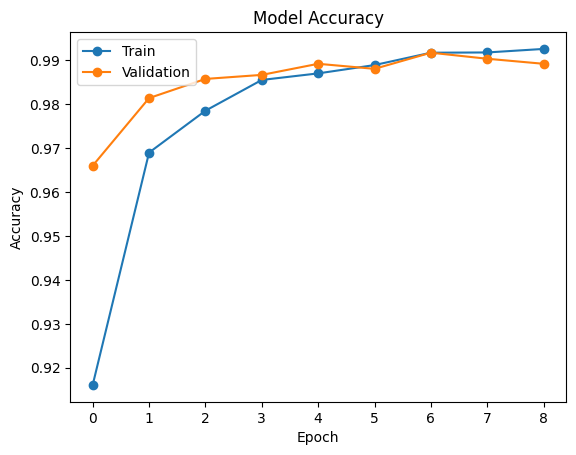

In [ ]:
# Plotting training & validation accuracy values
plt.plot(gru_model_history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(gru_model_history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### Accuracy Plot:

* Training accuracy steadily rises and flattens around 99.2% by epoch 7-8.
* Validation accuracy also increases but slightly plateaus at around 99% by epoch 6-7 and even shows a minor dip at epoch 8.
* The small gap between training and validation accuracy suggests that your model has learned well, but the slight drop in validation accuracy hints at the early signs of overfitting.

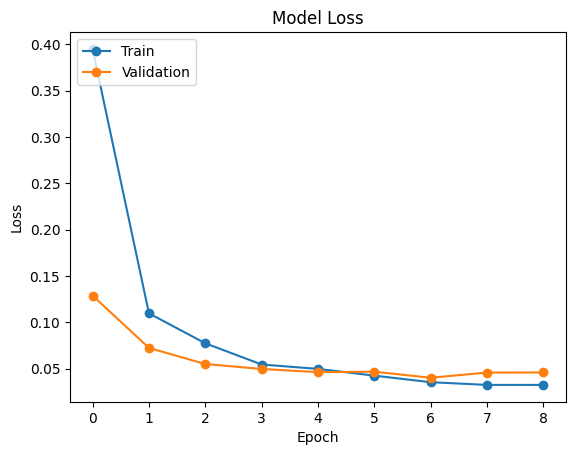

In [ ]:
# Plotting training & validation loss values
plt.plot(gru_model_history.history['loss'], label='Train Loss', marker='o')
plt.plot(gru_model_history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### Loss Plot:
* Training loss falls rapidly from 0.4 to around 0.03 in the first few epochs — typical for well-trained models — and becomes nearly flat by epoch 5.
* Validation loss also decreases steadily but stalls and slightly increases after epoch 6, again signaling overfitting.


In [ ]:
y_pred_prob = gru_model.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype(int)

171/171 ━━━━━━━━━━━━━━━━━━━━ 59s 334ms/step


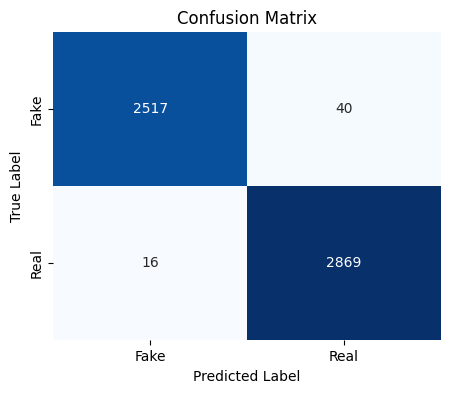

In [ ]:
# Generating confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])

# Labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2557
           1       0.99      0.99      0.99      2885

    accuracy                           0.99      5442
   macro avg       0.99      0.99      0.99      5442
weighted avg       0.99      0.99      0.99      5442



In [ ]:
gru_model.save("/content/drive/MyDrive/Fake_News_Classification/Saved_Models/gru_glove_model.h5")

In [ ]:
gru_model.save("/content/drive/MyDrive/Fake_News_Classification/Saved_Models/gru_glove_model.keras")

### Loading the Saved GRU Model

In [ ]:
# Load the model
gru_model = load_model("/content/drive/MyDrive/Fake_News_Classification/Saved_Models/gru_glove_model.keras")

#### Loading Saved Keras Tokenizer

In [ ]:
# Load the saved keras tokenizer
with open("/content/drive/MyDrive/Fake_News_Classification/Saved_Models/keras_tokenizer.pkl", "rb") as handle:
    keras_tokenizer = pickle.load(handle)

### **Predicting on Random News Articles from Internet**

In [ ]:
# Predict Using the Model
def predict_text(text):
  cleaned_text = clean_text(text)

  seq = keras_tokenizer.texts_to_sequences([cleaned_text])
  pad_seq = pad_sequences(seq, maxlen=300, padding='post')
  pred = gru_model.predict(pad_seq)[0][0]

  return "Real News" if pred >= 0.5 else "Fake News"

In [ ]:
sample_news = ''' Trump-Zelenskyy showdown: Takeaways from the most undiplomatic of White House exchanges
Volodymyr Zelenskyy’s extraordinary Oval Office showdown with the President and Vice President of the United States was every world leader’s worst nightmare come true in their dealings with the Donald Trump administration.
The consequence was a disaster for the President of Ukraine and his country, with hopes of a peace deal seeming as remote as it has ever been. President Trump said the shouting match was “great television”.First, none of the global norms that are associated with the behaviour of a world leader can be reasonably expected of Trump. His speech, behaviour,
comments, and social media posts run counter to those norms.Second, the world is now dealing with a US President who wants above all to be seen to be respected in front of his domestic audience. World leaders who understand that have swallowed their pride, zipped their mouths, smiled, and obliged him.This happened with Jordan’s King Abdullah II, when Trump talked about his plan for Gaza. The King did not contradict the President or provoke him in front of the TV crews. What he did instead was to issue a statement, via a tweet, rejecting the plan, after he got out of the White House.Other leaders, such as President Emmanuel Macron of France, and even Prime Minister Keir Starmer of the UK, have been
skilful and respectful. The French President smiled and held President Trump’s hand, but he also politely corrected him about Europe’s contribution to the Ukrainian war effort.Third, the Trump-Zelenskyy showdown has shown that each country is now on their own. Bilateral transactionalism is at its peak now. The new Washington doesn’t respect the norms and rules of the past, and each country has to look
out for their own interests — they can no longer depend on the US or its leadership. The reliability of the American establishment and power is no longer there.Fourth, South Block would be heaving a sigh of relief that Prime Minister Narendra Modi was able to navigate these choppy waters during his visit to the White House last month. The contentious issues of illegal immigration and high tariffs were raised respectfully, and the Indian
side was able to dodge the Trump bullet. That the Indian side came out of the White House with a target of a deal by this Fall, and that both sides decided to work on lowering tariffs, was perceived — and can be projected — as a victory by both sides.Fifth, the value of the classic old rule of diplomacy behind closed doors is becoming apparent now. That diplomacy is about talks and dialogue within the room, and not a spectacle for the cameras.This would mean that back-channel talks have more value than public statements and posturing.Sixth, it is now even more unlikely that India will express support for either country. New Delhi has walked the tightrope all along, and it will continue to stay away from taking sides, officials said. India will only point to its stated position: dialogue and diplomacy is the only path forward, and solutions cannot be found on the battlefield. On Friday, Prime Minister Narendra Modi and European Commission President Ursula von
der Leyen expressed “support for a just and lasting peace” “based on respect for international law, principles of the UN charter and territorial integrity and sovereignty”.Earlier this week, India abstained from voting on a draft resolution by Ukraine at the UN General Assembly that called for a “de-escalation, an early cessation of hostilities and a peaceful resolution”.Seventh, the biggest beneficiary of the drama in the White House is Russia and President Vladimir Putin. “I think Putin couldn’t be happier,” a European diplomat said, “They’re drinking vodka straight out of the bottle in the Kremlin tonight.”This was the outcome that Moscow would be happy about —
a break of trust and partnership between Zelenskyy and the US.Finally, what happens to Ukraine and the war now? Ukraine knows it cannot continue the fight without American support. That might mean Ukraine will come back to Trump.
'''

predict_text(sample_news)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


'Real News'

In [ ]:
sample_news = '''More women guards, GPS tracking, AI – slew of measures announced to enhance security at bus stands
Maharashtra Transport Minister Pratap Sarnaik has directed an immediate security audit of all bus stands and depots across the state and ordered to appoint more female security staff at all the depots.

In the meeting held today among various departments in Mumbai after the rape incident occurred at Swargate bus depot, Sarnaik issued orders to prohibit such incidents in future.

The Indian Express covered the bus depot and found miscreants loitering inside abandoned parked buses to smoke, consume alcohol, and the team also found some used condoms. Now, the minister has ordered the removal of all abandoned buses from depots and stands by April 15.
More female security guards to be appointed
Acknowledging the rising number of female passengers, Sarnaik proposed increasing the deployment of female security guards at bus stands. Additionally, he emphasized the urgency of clearing unregistered buses from bus stand areas, setting a firm deadline of April 15 for the task.
The minister also noted that the post of Chief Safety and Vigilance Officer in the State Transport Corporation remains vacant. He directed officials to appoint an Indian Police Service (IPS) officer to this position and to submit a proposal to the Home Department without delay.

AI-based CCTV, GPS tracking, and increased police patrolling
During the meeting, Sarnaik stressed the need for advanced surveillance systems at bus stands and depots, directing that an AI-based CCTV system be installed at all ST bus stands. He also mandated the installation of CCTV cameras in newly acquired buses and the rapid implementation of GPS tracking across the fleet. To enhance security, he called for increased police patrolling at bus stands in coordination with local law enforcement.
Highlighting the role of depot managers, Sarnaik stated that they should reside at the depot premises to ensure round-the-clock supervision. He further instructed that all ST employees working at bus stands must wear ide
Focus on cleanliness alongside safety
Sarnaik also underscored the importance of hygiene and passenger amenities at bus stops. He directed that toilets for women be constructed at every bus stand and that they should be spacious and well-maintained. Senior ST officials have been tasked with regularly reviewing cleanliness standards to ensure quality facilities for passengers.

“There can be no compromise on cleanliness. Passengers deserve quality facilities at bus stops,” Sarnaik asserted, instructing officials to prioritize both safety and hygiene in their efforts.With these directives, the state government aims to significantly improve passenger safety and overall infrastructure at Maharashtra’s bus depots and stands.These decisions were taken during a review meeting on women’s safety at bus stands held at the office of the Additional Chief Secretary (Transport). Key attendees included Additional Chief Secretary and Chairman of the ST Corporation Sanjay Sethi, Transport Commissioner and Vice Chairman & Managing Director (in charge) of the ST Corporation Vivek Bhimanwar, Joint Secretary Rajendra Holkar, and other senior officials.

'''

predict_text(sample_news)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


'Real News'

In [ ]:
sample_news = '''
Breaking: Scientists Discover Secret Alien Base on the Moon!
In a shocking revelation, a team of independent researchers claims to have discovered an alien base on the dark side of the Moon.
According to Dr. Marcus Reynolds, a former NASA scientist turned whistleblower,
the structures found resemble massive extraterrestrial settlements."We've analyzed satellite images and found geometric patterns
and structures that are not naturally occurring," Reynolds stated.
"This is undeniable evidence that an advanced civilization has been—or
still is—present on the Moon."The U.S. government, however, has remained silent on the matter.
Conspiracy theorists argue that NASA has covered up evidence of extraterrestrial life for decades.
"Why do you think the Apollo missions suddenly stopped?" asked Emily Carter, a well-known UFO researcher.
Adding fuel to the fire, a former Pentagon official confirmed in an interview that there have been
"classified discussions" regarding unidentified lunar activity. Social media is now ablaze with speculation.
Is this the biggest cover-up in history? What is NASA hiding from us?
'''

predict_text(sample_news)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


'Fake News'

In [ ]:
sample_text = '''NASA Confirms Earth Will Experience 15 Days of Total Darkness in March 2025
In a shocking revelation, NASA has confirmed that Earth will experience 15 consecutive days of total
darkness from March 10 to March 25, 2025 due to an astronomical event known as the “Blackout Alignment”.
According to NASA scientists, a rare planetary alignment between Jupiter and Venus will block out 90%
of sunlight reaching Earth, causing a global blackout.NASA Administrator Dr. Mark Reynolds stated
that this is a once-in-a-lifetime event, and people should prepare for extreme cold and power
failures during these two weeks. The government has urged citizens to stockpile food, water,
and emergency supplies. However, some experts warn that this could have serious effects on
human psychology and global economies. '''

predict_text(sample_text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


'Fake News'

### Till now all predictions were correct..

#### Below is a wrong prediction. The below is a fake news generated by GPT. GRU model predicted it to be true.

In [ ]:
sample_news = '''
World Health Organization Issues Urgent Warning About New ‘Stealth Virus’ Spreading Globally
Geneva, Switzerland – The World Health Organization (WHO) has issued an urgent global health advisory after detecting the rapid spread of a mysterious new virus, dubbed the “Stealth Virus”, which reportedly evades standard diagnostic tests.

According to Dr. Eleanor Whitman, a leading infectious disease expert at WHO, the virus presents mild symptoms initially—such as fatigue, mild fever, and headaches—before rapidly progressing into severe respiratory distress within days.

“What makes this virus particularly concerning is its ability to remain undetectable in early testing,” Dr. Whitman said in a statement. “By the time severe symptoms appear, it may already have spread to multiple contacts.”

Silent Outbreaks Reported in Multiple Countries
Health officials in Germany, Canada, India, and Australia have already reported clusters of unexplained pneumonia cases that do not respond to conventional treatments. In the United States, an unnamed hospital in New York has confirmed treating multiple cases with “unknown viral origin.”

Dr. Marcus Caldwell, a senior virologist at Harvard Medical School, warned that global transmission may have already begun.

“Given the silent nature of early infection, many individuals could already be spreading the virus without realizing it. This could be worse than anything we've seen before,” he stated.

WHO Recommends Immediate Preventative Measures
Although no official lockdowns have been announced, WHO has advised all nations to begin strict monitoring of flu-like cases and consider reintroducing certain pandemic-era precautions, including mask mandates in high-risk areas.

Governments Remain Silent
Despite growing concerns, no major government has publicly acknowledged the threat. Some experts believe that officials are deliberately downplaying the situation to prevent panic.

With global travel at pre-pandemic levels, experts fear that the Stealth Virus could be spreading much faster than current reports suggest.

Stay tuned for updates as this developing situation unfolds.

'''

predict_text(sample_news)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


'Real News'

### 🔍 Possible Issues :

1. **Model Struggles with Realistic-Sounding Fake News:**
* This article mimics real news by including official names (WHO, Harvard, Dr. Caldwell).
* Fake news is often written in a factual, neutral tone, making it hard to distinguish from real news.

2. **Insufficient Context or Short Input Length**:
* Model truncates text (e.g., only analyzing the first 200-300 words), it might miss key signals that expose the article as fake.
* Some fake news only reveals itself in later paragraphs.

3. **Overreliance on Keywords Instead of Meaning**:
* If model mostly relies on keywords (like "WHO", "scientists", "virus"), it might classify scientific-sounding fake news as real.
* Fake news often borrows credibility by using real organizations but mixes in false claims.



### Another Possible Issue:
* Our dataset has mostly news realated to politics.
Models might have learned strong political news patterns but failed to generalize to other topics due to class imbalance or lack of diverse representation in the dataset.

### 🛠 Next Steps:

##### Use contextual embeddings like BERT, RoBERTa, or T5 instead of traditional word embeddings.

A transformer-based model (like BERT, RoBERTa, or DeBERTa) could be a better choice because it captures contextual information more effectively and generalizes well across domains.